In [2]:
import spacy
import timeit
import math
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from collections import Counter
from lxml import etree
from glob import glob
from unicodedata import normalize

In [3]:
%matplotlib inline

In [5]:
nlp = spacy.load('fr_core_news_lg')

In [6]:
def est_canon(tree):
    if tree.find(".//profileDesc") is not None:
        profil = tree.find(".//profileDesc")
        if profil.get("tag") == "canon":
            return True
        else:
            return False

In [7]:
def bigrammize(list_lemma):
    list_bigram = []
    for indice_lemma in range(len(list_lemma)-1):
        bigram = list_lemma[indice_lemma]+'_'+list_lemma[indice_lemma+1]
        list_bigram.append(bigram)
    return list_bigram

In [8]:
def rollingnwords(list_lemma, n):
    i = 0 # i stocke l'indice auquel on est dans le rolling
    list_rolling = []
    while i-n < len(list_lemma):
        list_rolling.append(list_lemma[i:i+n])
        i+=n
    return list_rolling    

In [9]:
def rolling_type_token(rolling_list_lemma, window):
    list_rolling_type_token = []
    for list_lemma in rolling_list_lemma:
        lemmes_freq = Counter()
        for lemma in list_lemma:
            lemmes_freq[lemma] += 1
        if sum(lemmes_freq.values()) == window:
            list_rolling_type_token.append(round(len(lemmes_freq)/sum(lemmes_freq.values()),2))                                      
    return list_rolling_type_token

In [10]:
def rolling_shannon(rolling_list_bigram):
    shannon_measures = []
    for list_bigram in rolling_list_bigram:
        shannon_sum = 0 # initialisation de l'indice de shannon
        dict_conteur = Counter(list_bigram)
        for bigram in list_bigram:
            # on recupere la proportion pi de chaque bigram par rapport à tous les autres bigrams
            prop = dict_conteur[bigram]/len(list_bigram)
            shannon_courant = prop * (math.log(prop, 2))
            # on met à jour l'indice de shannon
            shannon_sum += shannon_courant
        shannon_measures.append(round(shannon_sum * -1,2))
    return shannon_measures

In [11]:
def lemmatize(path):
    list_lemma = []
    with open(path, encoding="utf8") as file:
        tree = etree.parse(file)
        tag = est_canon(tree)
        if tag == True:
            print("canon")
        else:
            print("non_canon")
        if tree.findall(".//p"):
            for paragraphe in tree.findall(".//p"):
                if paragraphe.text:
                    clean_text = normalize("NFKD", paragraphe.text)
                    docs = nlp(clean_text)
                    for token in docs:
                        if token.pos_ != "PUNCT" and "SPACE" and "X" and "SYM":
                            list_lemma.append(token.lemma_)
    return list_lemma, tag

rolling avec passage type-token et shannon

In [13]:
path_name='corpus_test/*.xml'
window=1000

In [14]:
def moulinette(path_name, window):
    
    canon = False

    annee_canon = []
    annee_archive = []
    
    type_token_canon_df = pd.DataFrame()
    type_token_archive_df = pd.DataFrame()

    shannon_canon_df = pd.DataFrame()
    shannon_archive_df = pd.DataFrame()

    for doc in glob(path_name):
        doc_name = path.splitext(path.basename(doc))[0]
        date = doc_name.split("_")[0]
        print(doc_name)

        list_lemma, canon = lemmatize(doc)
        
        rolling_list_lemma = rollingnwords(list_lemma, window)
        type_token = rolling_type_token(rolling_list_lemma, window)
        
        list_bigram = bigrammize(list_lemma)
        rolling_list_bigram = rollingnwords(list_bigram, window)
        
        indice_shannon = rolling_shannon(rolling_list_bigram)
        
        if canon:
            t_canon = pd.Series(type_token, name=doc_name)
            type_token_canon_df = pd.concat([type_token_canon_df, t_canon], axis=1)
            s_canon = pd.Series(indice_shannon, name=doc_name)
            shannon_canon_df = pd.concat([shannon_canon_df, s_canon], axis=1)
            annee_canon.append(date)
        else:
            t_archive = pd.Series(type_token, name=doc_name)
            type_token_archive_df = pd.concat([type_token_archive_df, t_archive], axis=1)
            s_archive = pd.Series(indice_shannon, name=doc_name)
            shannon_archive_df = pd.concat([shannon_archive_df, s_archive], axis=1)
            annee_archive.append(date)
            
    return annee_canon, annee_archive, type_token_canon_df, type_token_archive_df, shannon_canon_df, shannon_archive_df

In [15]:
annee_canon, annee_archive, type_token_canon_df, type_token_archive_df, shannon_canon_df, shannon_archive_df = moulinette(path_name, window)

1828_Kock-Paul-de_Jean
non_canon
1829_Hugo-Victor_Le-dernier-jour-d-un-condamne
canon
1831_Balzac-Honore-de_La-Peau-de-chagrin-ed-Gosselin
canon
1832_Sand-George_Indiana
canon
1832_Vigny-Alfred-de_Stello
canon
1833_Corbiere-Edouard_La-mer-et-les-marins-Scenes-maritimes
non_canon
1833_Servan-Felix_Claudia-ou-Les-prieres-d-une-jeune-fille
non_canon
1834_Foa-Eugenie_La-Femme-a-la-mode
non_canon
1836_Musset-Alfred-de_La-Confession-d-un-enfant-du-siecle-par-Alfred-de-Musset-nouvelle-edition-(1878)
canon
1838_Gautier-Theophile_Fortunio
canon
1839_Karr-Alphonse_Clotilde
non_canon
1840_Dumas-Alexandre_Le-Capitaine-Pamphile
canon
1843_Le-Roux-Alfred_Edouard-Aubert
non_canon
1843_Tillier-Claude_Mon-oncle-Benjamin
non_canon
1844_Tarbe-Des-Sablons-Michelle-Catherine-Josephine-Guespereau-Mme-Sebastien-Andre_Onesie-ou-les-Soirees-de-l-abbaye-suivie-de-Enguerrand-ou-le-Duel
non_canon
1848_Musset-Paul-de_La-Chevre-Jaune
non_canon
1849_Chateaubriand-François-Rene-de_Memoires-d-Outre-Tombe-Tome-1
canon


type_token

In [16]:
shannon_archive_df.describe()

,1828_Kock-Paul-de_Jean,1833_Corbiere-Edouard_La-mer-et-les-marins-Scenes-maritimes,1833_Servan-Felix_Claudia-ou-Les-prieres-d-une-jeune-fille,1834_Foa-Eugenie_La-Femme-a-la-mode,1839_Karr-Alphonse_Clotilde,1843_Le-Roux-Alfred_Edouard-Aubert,1843_Tillier-Claude_Mon-oncle-Benjamin,1844_Tarbe-Des-Sablons-Michelle-Catherine-Josephine-Guespereau-Mme-Sebastien-Andre_Onesie-ou-les-Soirees-de-l-abbaye-suivie-de-Enguerrand-ou-le-Duel,1848_Musset-Paul-de_La-Chevre-Jaune,1857_Aimard-Gustave_Les-trappeurs-de-l-Arkansas,1859_Ulbach-Louis_Pauline-Foucault
count,108.000000,55.000000,57.000000,40.000000,77.000000,40.000000,89.000000,93.000000,40.000000,96.000000,135.000000
mean,13.767593,13.975455,13.097193,12.577500,14.309740,12.394750,13.617528,12.492366,12.599250,13.465312,13.062148
std,1.575073,2.554560,2.200931,2.152092,2.117138,2.191551,1.793808,1.412430,2.236355,1.561284,1.318533
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.347500,13.405000,12.890000,12.485000,13.520000,12.452500,12.940000,12.340000,12.445000,13.085000,12.715000
50%,13.825000,14.190000,13.410000,12.770000,14.240000,12.745000,13.580000,12.640000,12.980000,13.440000,13.110000
75%,14.212500,14.830000,13.860000,13.127500,15.040000,13.070000,14.340000,12.870000,13.405000,14.015000,13.495000
max,17.200000,18.640000,16.960000,15.710000,20.260000,13.990000,17.000000,13.760000,14.430000,15.720000,15.940000


In [21]:
shannon_canon_df.describe()

,1829_Hugo-Victor_Le-dernier-jour-d-un-condamne,1831_Balzac-Honore-de_La-Peau-de-chagrin-ed-Gosselin,1832_Sand-George_Indiana,1832_Vigny-Alfred-de_Stello,1836_Musset-Alfred-de_La-Confession-d-un-enfant-du-siecle-par-Alfred-de-Musset-nouvelle-edition-(1878),1838_Gautier-Theophile_Fortunio,1840_Dumas-Alexandre_Le-Capitaine-Pamphile,1849_Chateaubriand-François-Rene-de_Memoires-d-Outre-Tombe-Tome-1,1857_Flaubert-Gustave_Madame-Bovary
count,38.000000,102.000000,100.000000,67.000000,98.000000,52.000000,72.000000,99.000000,123.000000
mean,13.408684,12.415196,13.175100,13.035373,13.267755,12.333462,13.990694,13.761919,12.169675
std,2.658510,1.430199,1.496822,1.824382,1.594105,1.850257,2.073968,1.760639,1.225878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.897500,12.110000,12.830000,12.785000,12.942500,12.155000,13.302500,13.130000,11.905000
50%,13.545000,12.440000,13.105000,13.250000,13.325000,12.475000,14.250000,13.830000,12.320000
75%,14.120000,12.895000,13.602500,13.525000,13.767500,12.822500,15.065000,14.380000,12.545000
max,19.900000,14.510000,15.800000,15.440000,16.360000,14.970000,17.820000,17.150000,13.650000


In [92]:
type_token_archive_df.describe()

,1828_Kock-Paul-de_Jean,1833_Corbiere-Edouard_La-mer-et-les-marins-Scenes-maritimes,1833_Servan-Felix_Claudia-ou-Les-prieres-d-une-jeune-fille,1834_Foa-Eugenie_La-Femme-a-la-mode,1839_Karr-Alphonse_Clotilde,1843_Le-Roux-Alfred_Edouard-Aubert,1843_Tillier-Claude_Mon-oncle-Benjamin,1844_Tarbe-Des-Sablons-Michelle-Catherine-Josephine-Guespereau-Mme-Sebastien-Andre_Onesie-ou-les-Soirees-de-l-abbaye-suivie-de-Enguerrand-ou-le-Duel,1848_Musset-Paul-de_La-Chevre-Jaune,1857_Aimard-Gustave_Les-trappeurs-de-l-Arkansas,1859_Ulbach-Louis_Pauline-Foucault
count,946.000000,469.000000,487.000000,342.000000,670.000000,338.000000,775.000000,809.000000,338.000000,838.000000,1182.000000
mean,0.654376,0.646141,0.661006,0.673830,0.626776,0.694527,0.663690,0.683659,0.675296,0.675919,0.671235
std,0.037497,0.044513,0.045316,0.041627,0.047156,0.033587,0.041391,0.034651,0.034991,0.036708,0.038718
min,0.520000,0.430000,0.500000,0.550000,0.450000,0.580000,0.520000,0.590000,0.550000,0.560000,0.560000
25%,0.630000,0.620000,0.640000,0.650000,0.600000,0.670000,0.640000,0.660000,0.650000,0.650000,0.650000
50%,0.650000,0.650000,0.660000,0.670000,0.630000,0.700000,0.660000,0.680000,0.670000,0.670000,0.670000
75%,0.680000,0.680000,0.690000,0.700000,0.650000,0.720000,0.690000,0.710000,0.700000,0.700000,0.700000
max,0.770000,0.750000,0.810000,0.780000,0.760000,0.800000,0.790000,0.800000,0.760000,0.810000,0.810000


In [93]:
type_token_canon_df.describe()

,1829_Hugo-Victor_Le-dernier-jour-d-un-condamne,1831_Balzac-Honore-de_La-Peau-de-chagrin-ed-Gosselin,1832_Sand-George_Indiana,1832_Vigny-Alfred-de_Stello,1836_Musset-Alfred-de_La-Confession-d-un-enfant-du-siecle-par-Alfred-de-Musset-nouvelle-edition-(1878),1838_Gautier-Theophile_Fortunio,1840_Dumas-Alexandre_Le-Capitaine-Pamphile,1849_Chateaubriand-François-Rene-de_Memoires-d-Outre-Tombe-Tome-1,1857_Flaubert-Gustave_Madame-Bovary
count,322.000000,888.000000,875.000000,577.000000,854.000000,449.000000,623.000000,863.000000,1073.000000
mean,0.655807,0.694820,0.666446,0.652461,0.661089,0.688062,0.663981,0.656651,0.706822
std,0.045063,0.038064,0.039215,0.043722,0.043731,0.035764,0.040163,0.039513,0.033918
min,0.450000,0.520000,0.520000,0.480000,0.460000,0.560000,0.420000,0.480000,0.610000
25%,0.630000,0.670000,0.650000,0.630000,0.640000,0.660000,0.650000,0.630000,0.680000
50%,0.660000,0.700000,0.660000,0.650000,0.660000,0.690000,0.660000,0.650000,0.710000
75%,0.687500,0.720000,0.690000,0.680000,0.690000,0.710000,0.690000,0.680000,0.730000
max,0.760000,0.810000,0.770000,0.790000,0.800000,0.780000,0.790000,0.770000,0.810000


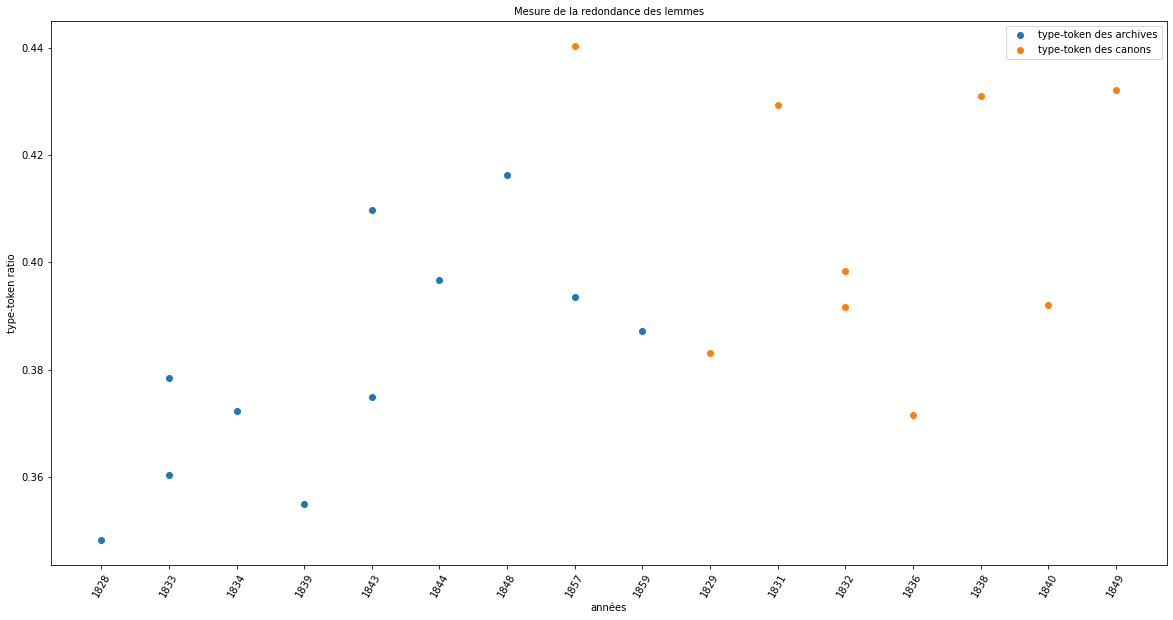

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(annee_archive, type_token_archive_df.mean(), label = 'type-token des archives')
plt.scatter(annee_canon, type_token_canon_df.mean(), label = 'type-token des canons')
plt.ylabel('type-token ratio', fontsize=10)
plt.xlabel('années', fontsize=10)
plt.xticks(rotation=60)

plt.title('Mesure de la redondance des lemmes', fontsize=10)
plt.legend(prop={'size': 10})
plt.show()

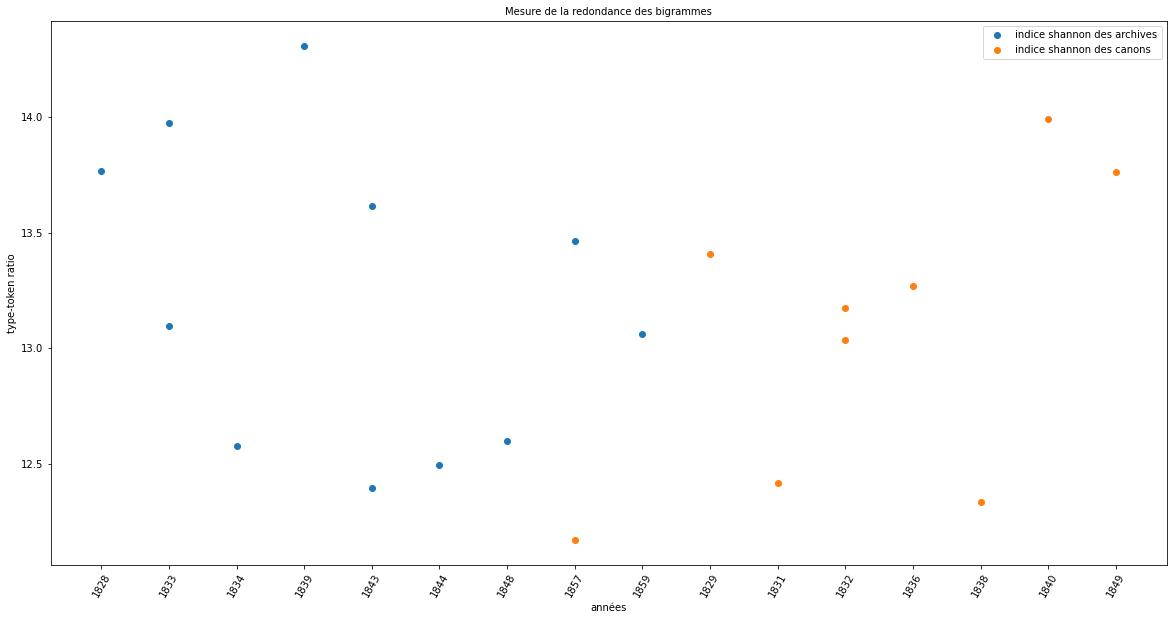

In [23]:
plt.figure(figsize=(20,10))
plt.scatter(annee_archive, shannon_archive_df.mean(), label = 'indice shannon des archives')
plt.scatter(annee_canon, shannon_canon_df.mean(), label = 'indice shannon des canons')
plt.ylabel('type-token ratio', fontsize=10)
plt.xlabel('années', fontsize=10)
plt.xticks(rotation=60)

plt.title('Mesure de la redondance des bigrammes', fontsize=10)
plt.legend(prop={'size': 10})
plt.show()

In [24]:
df_VH = pd.concat([type_token_canon_df['1829_Hugo-Victor_Le-dernier-jour-d-un-condamne'], shannon_canon_df['1829_Hugo-Victor_Le-dernier-jour-d-un-condamne']], axis=1, keys=['type_token_canon_df', 'shannon_canon_df'])

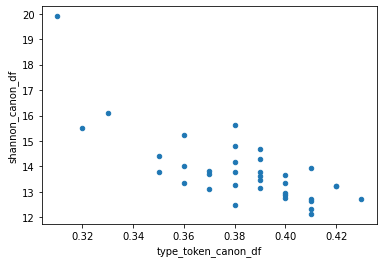

In [28]:
df_VH.plot(x ='type_token_canon_df', y='shannon_canon_df', kind = 'scatter')
plt.show()

In [25]:
df_EF = pd.concat([type_token_archive_df['1834_Foa-Eugenie_La-Femme-a-la-mode'], shannon_archive_df['1834_Foa-Eugenie_La-Femme-a-la-mode']], axis=1, keys=['type_token_archive_df', 'shannon_archive_df']) 

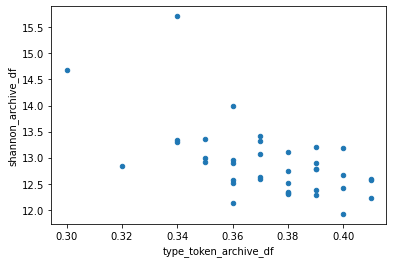

In [30]:
df_EF.plot(x ='type_token_archive_df', y='shannon_archive_df', kind = 'scatter')
plt.show()